In [5]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pytesseract

* 함수

In [10]:
# 이미지 출력 함수
def imshow(img, size=(30, 45)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

# 이미지 전체 테두리 지우기, 경계선 검출시 필요
def draw_edge(img, margin=1):
    img[0:margin, :], img[-margin:, :], img[:, 0:margin], img[:, -margin:] = 255, 255, 255, 255
    return img

* 데이터불러오기

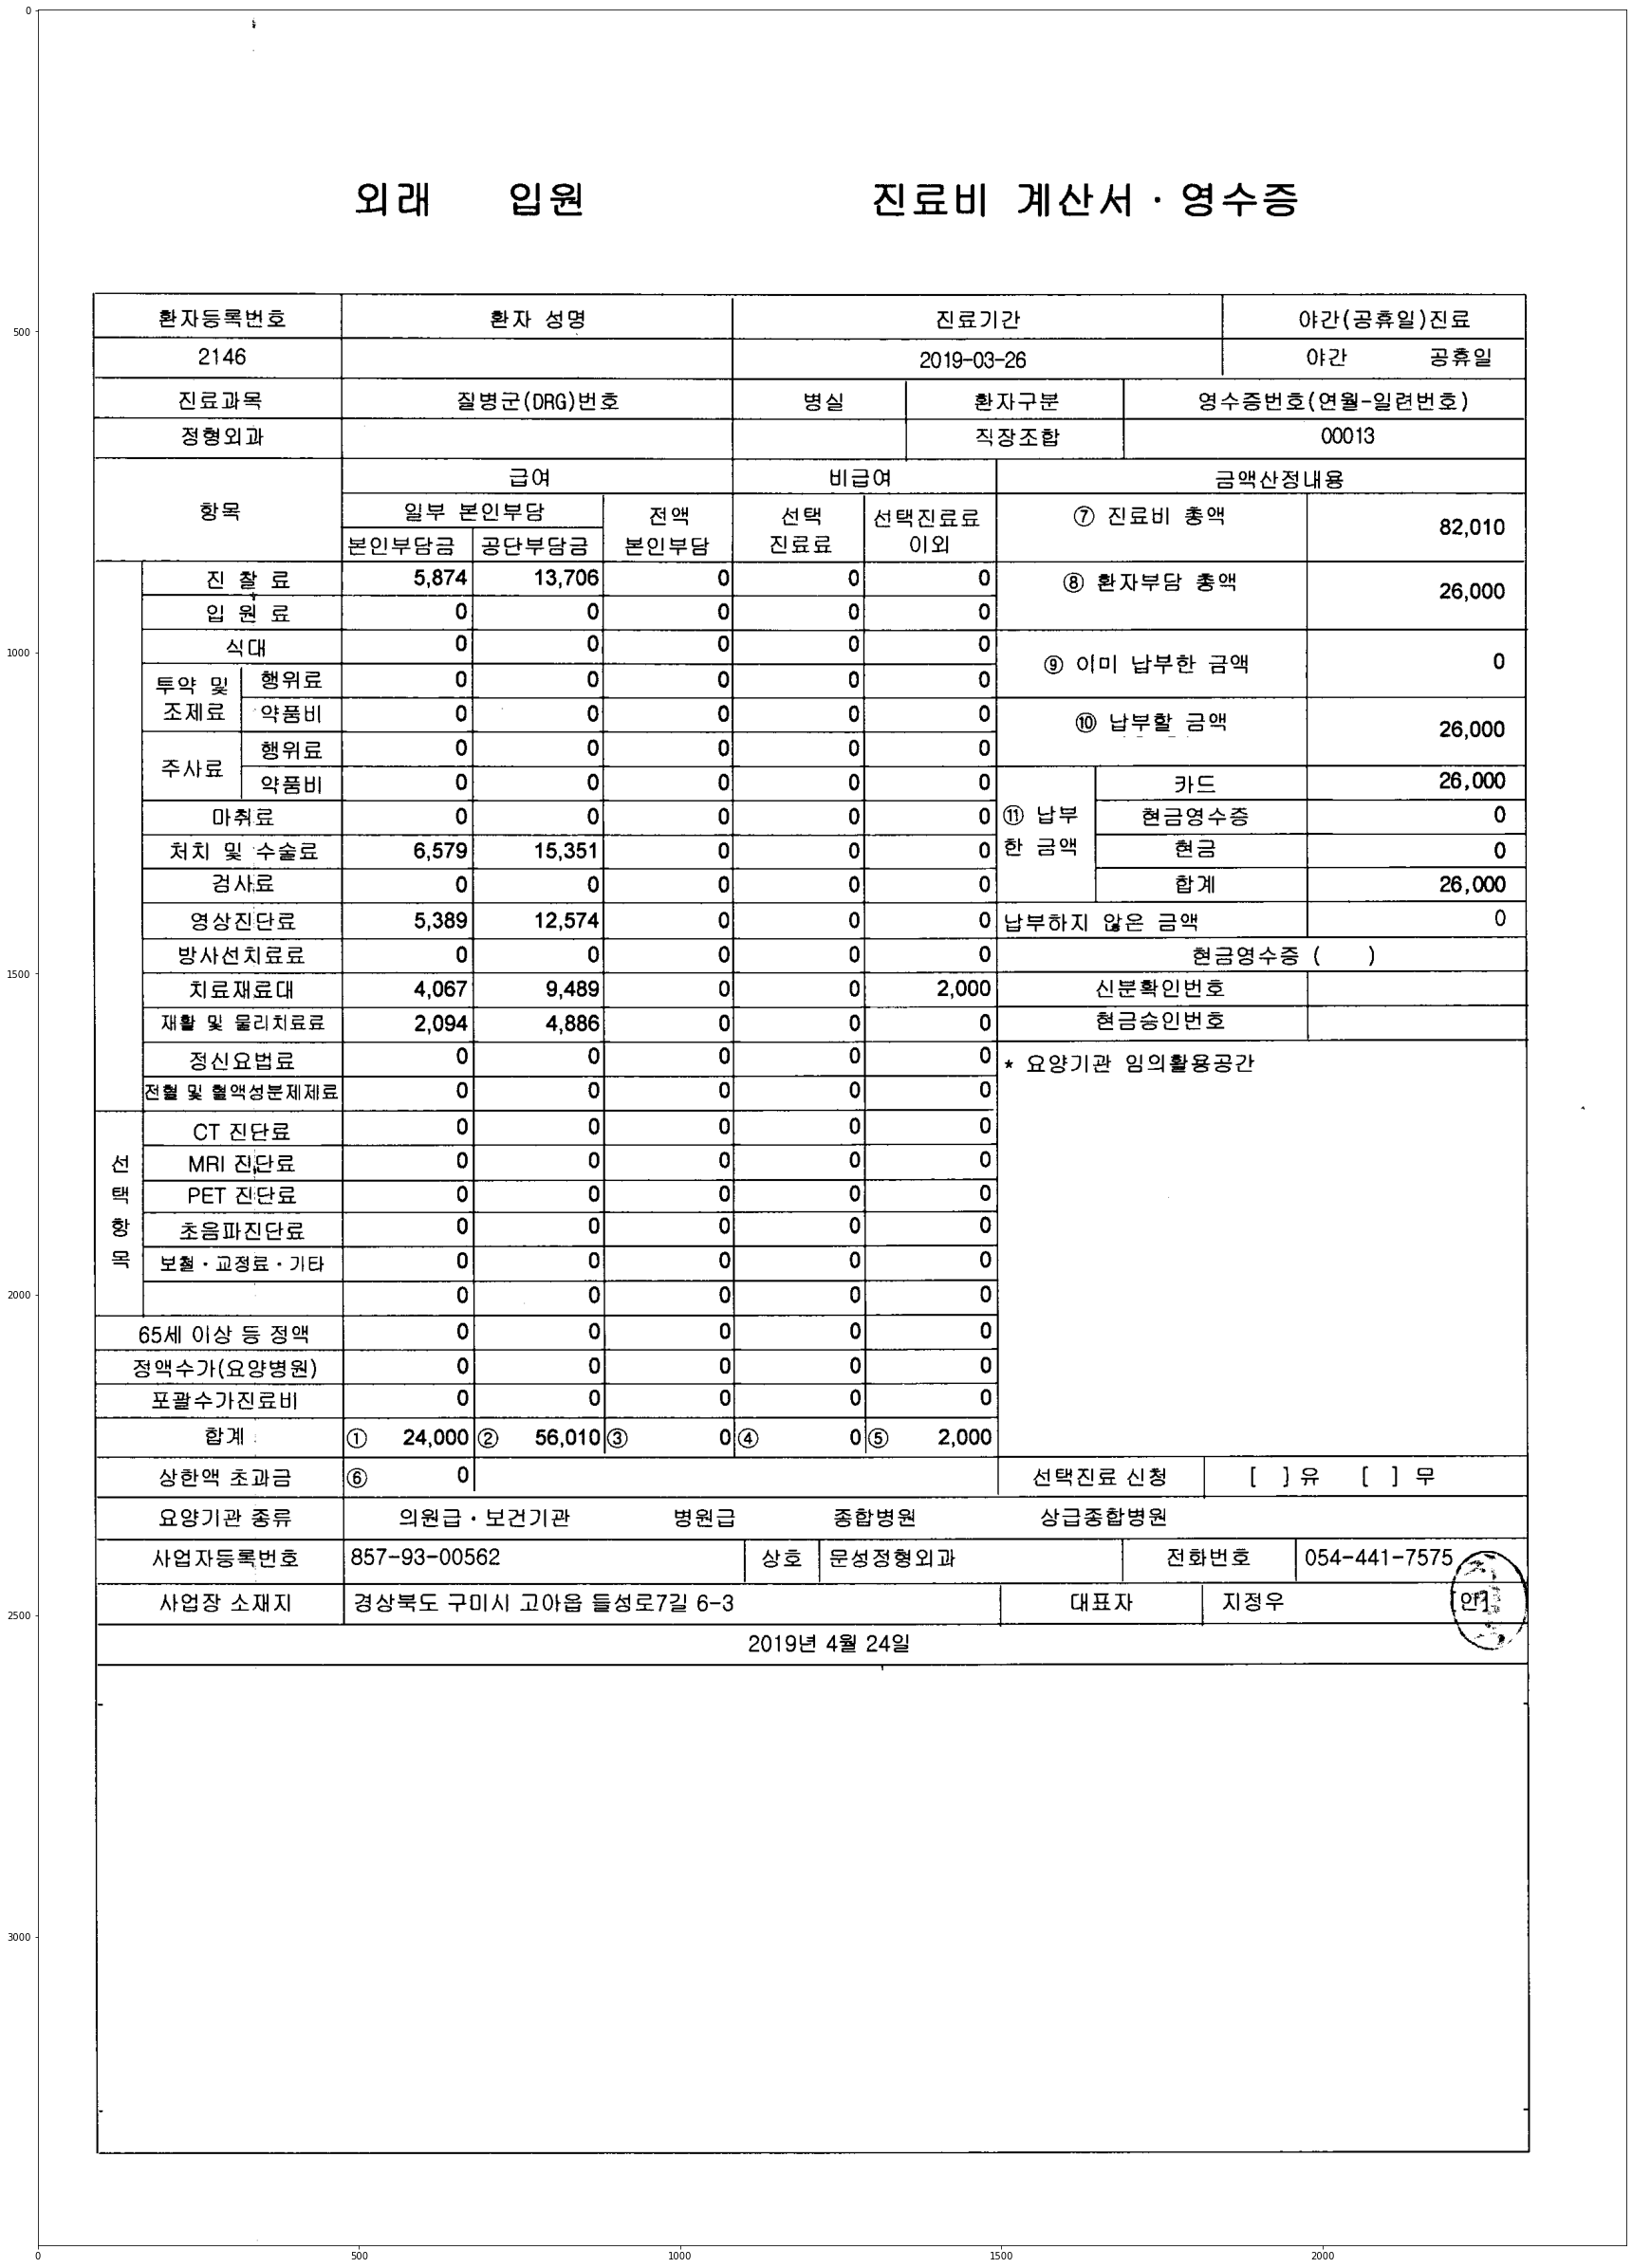

In [11]:
# PARAMETERS
path = 'img/'            # 원본이미지 경로
proc_path = 'proc_img/'  # 이진화 후 이미지 경로
cell_path = 'cell_img/'  # 셀구역을 표현한 이미지
split_path = 'sp_img/'   # 셀단위로 쪼개진 이미지
filename = 'image01.jpg' # 파일명

img = cv2.imread(path+filename, cv2.IMREAD_GRAYSCALE)  # 이미지 불러오기

# 이진화
bi_thr = 190
ret, bi_img = cv2.threshold(img, bi_thr, 255, cv2.THRESH_BINARY)

imshow(bi_img)

* 직선검출

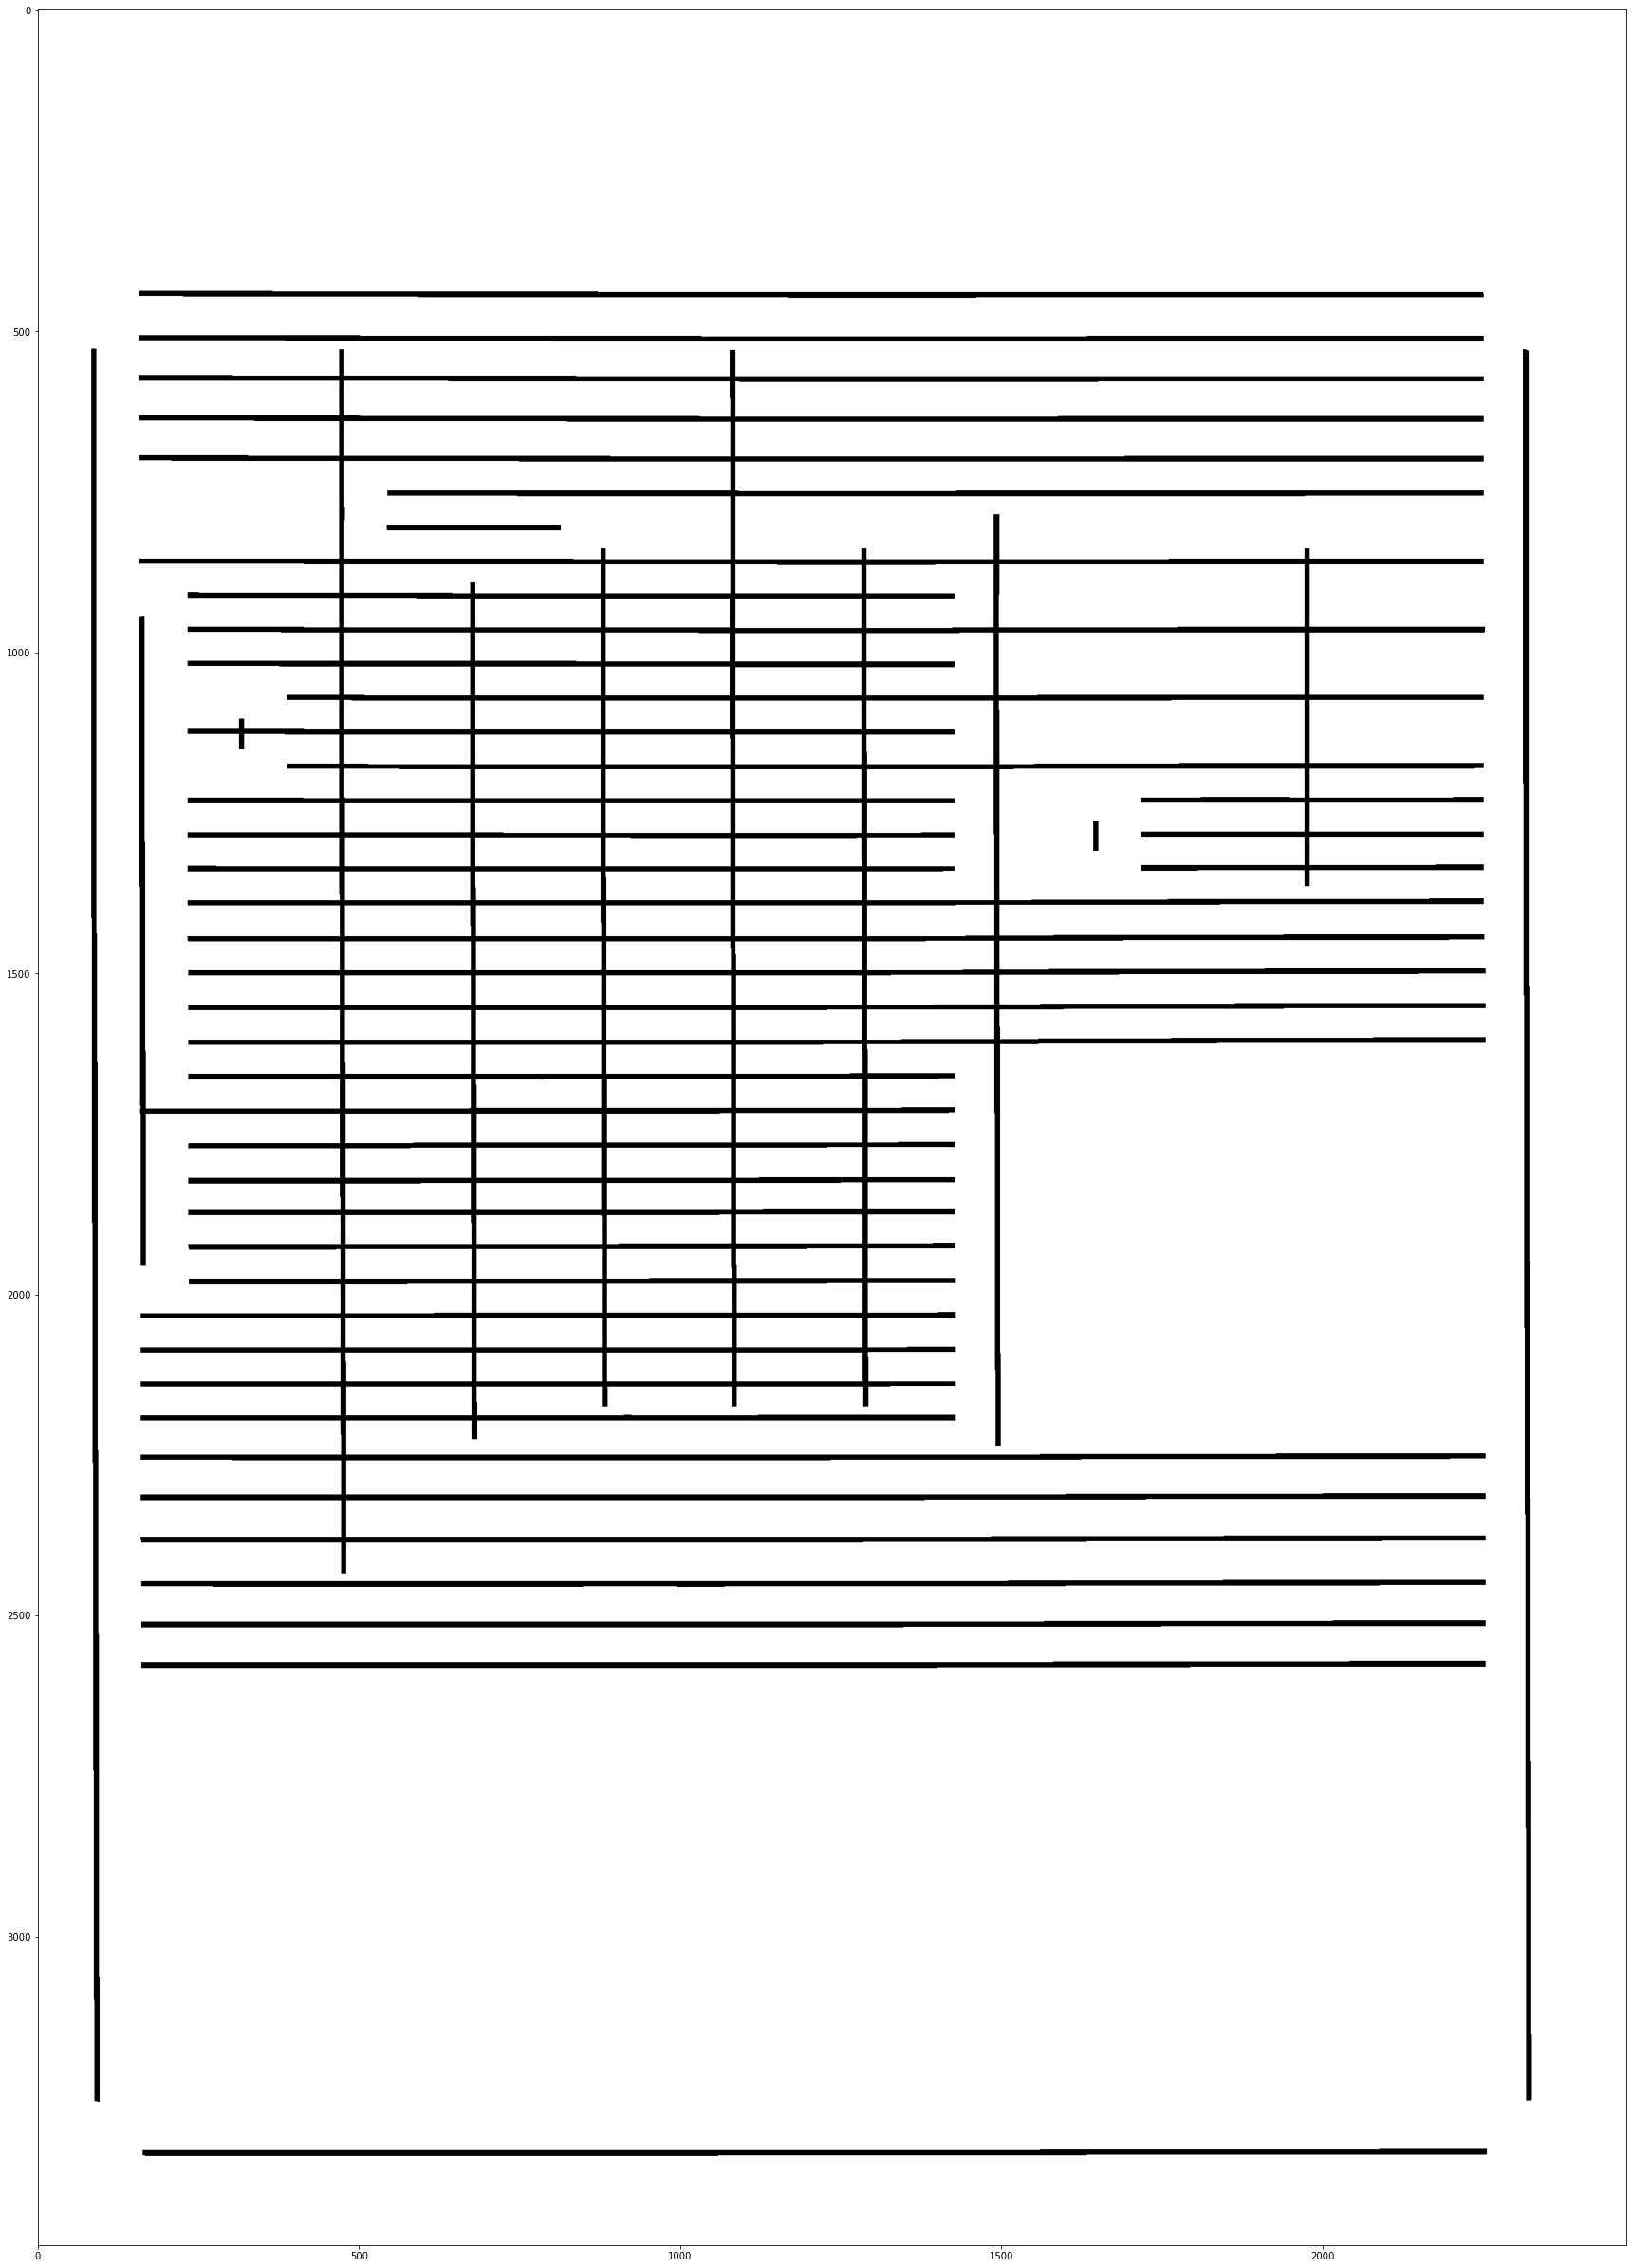

In [12]:
kernel_erode = np.ones((3, 3), np.uint8)
erotion = cv2.erode(bi_img, kernel_erode, iterations=3)

kernel_del_row = np.ones((1, 30), np.uint8)
kernel_del_col = np.ones((30, 1), np.uint8)

dilation_row = cv2.dilate(erotion, kernel_del_row, iterations=5)
dilation_col = cv2.dilate(erotion, kernel_del_col, iterations=6)

imshow(cv2.min(dilation_row, dilation_col))

* 라인제거(오래걸림)

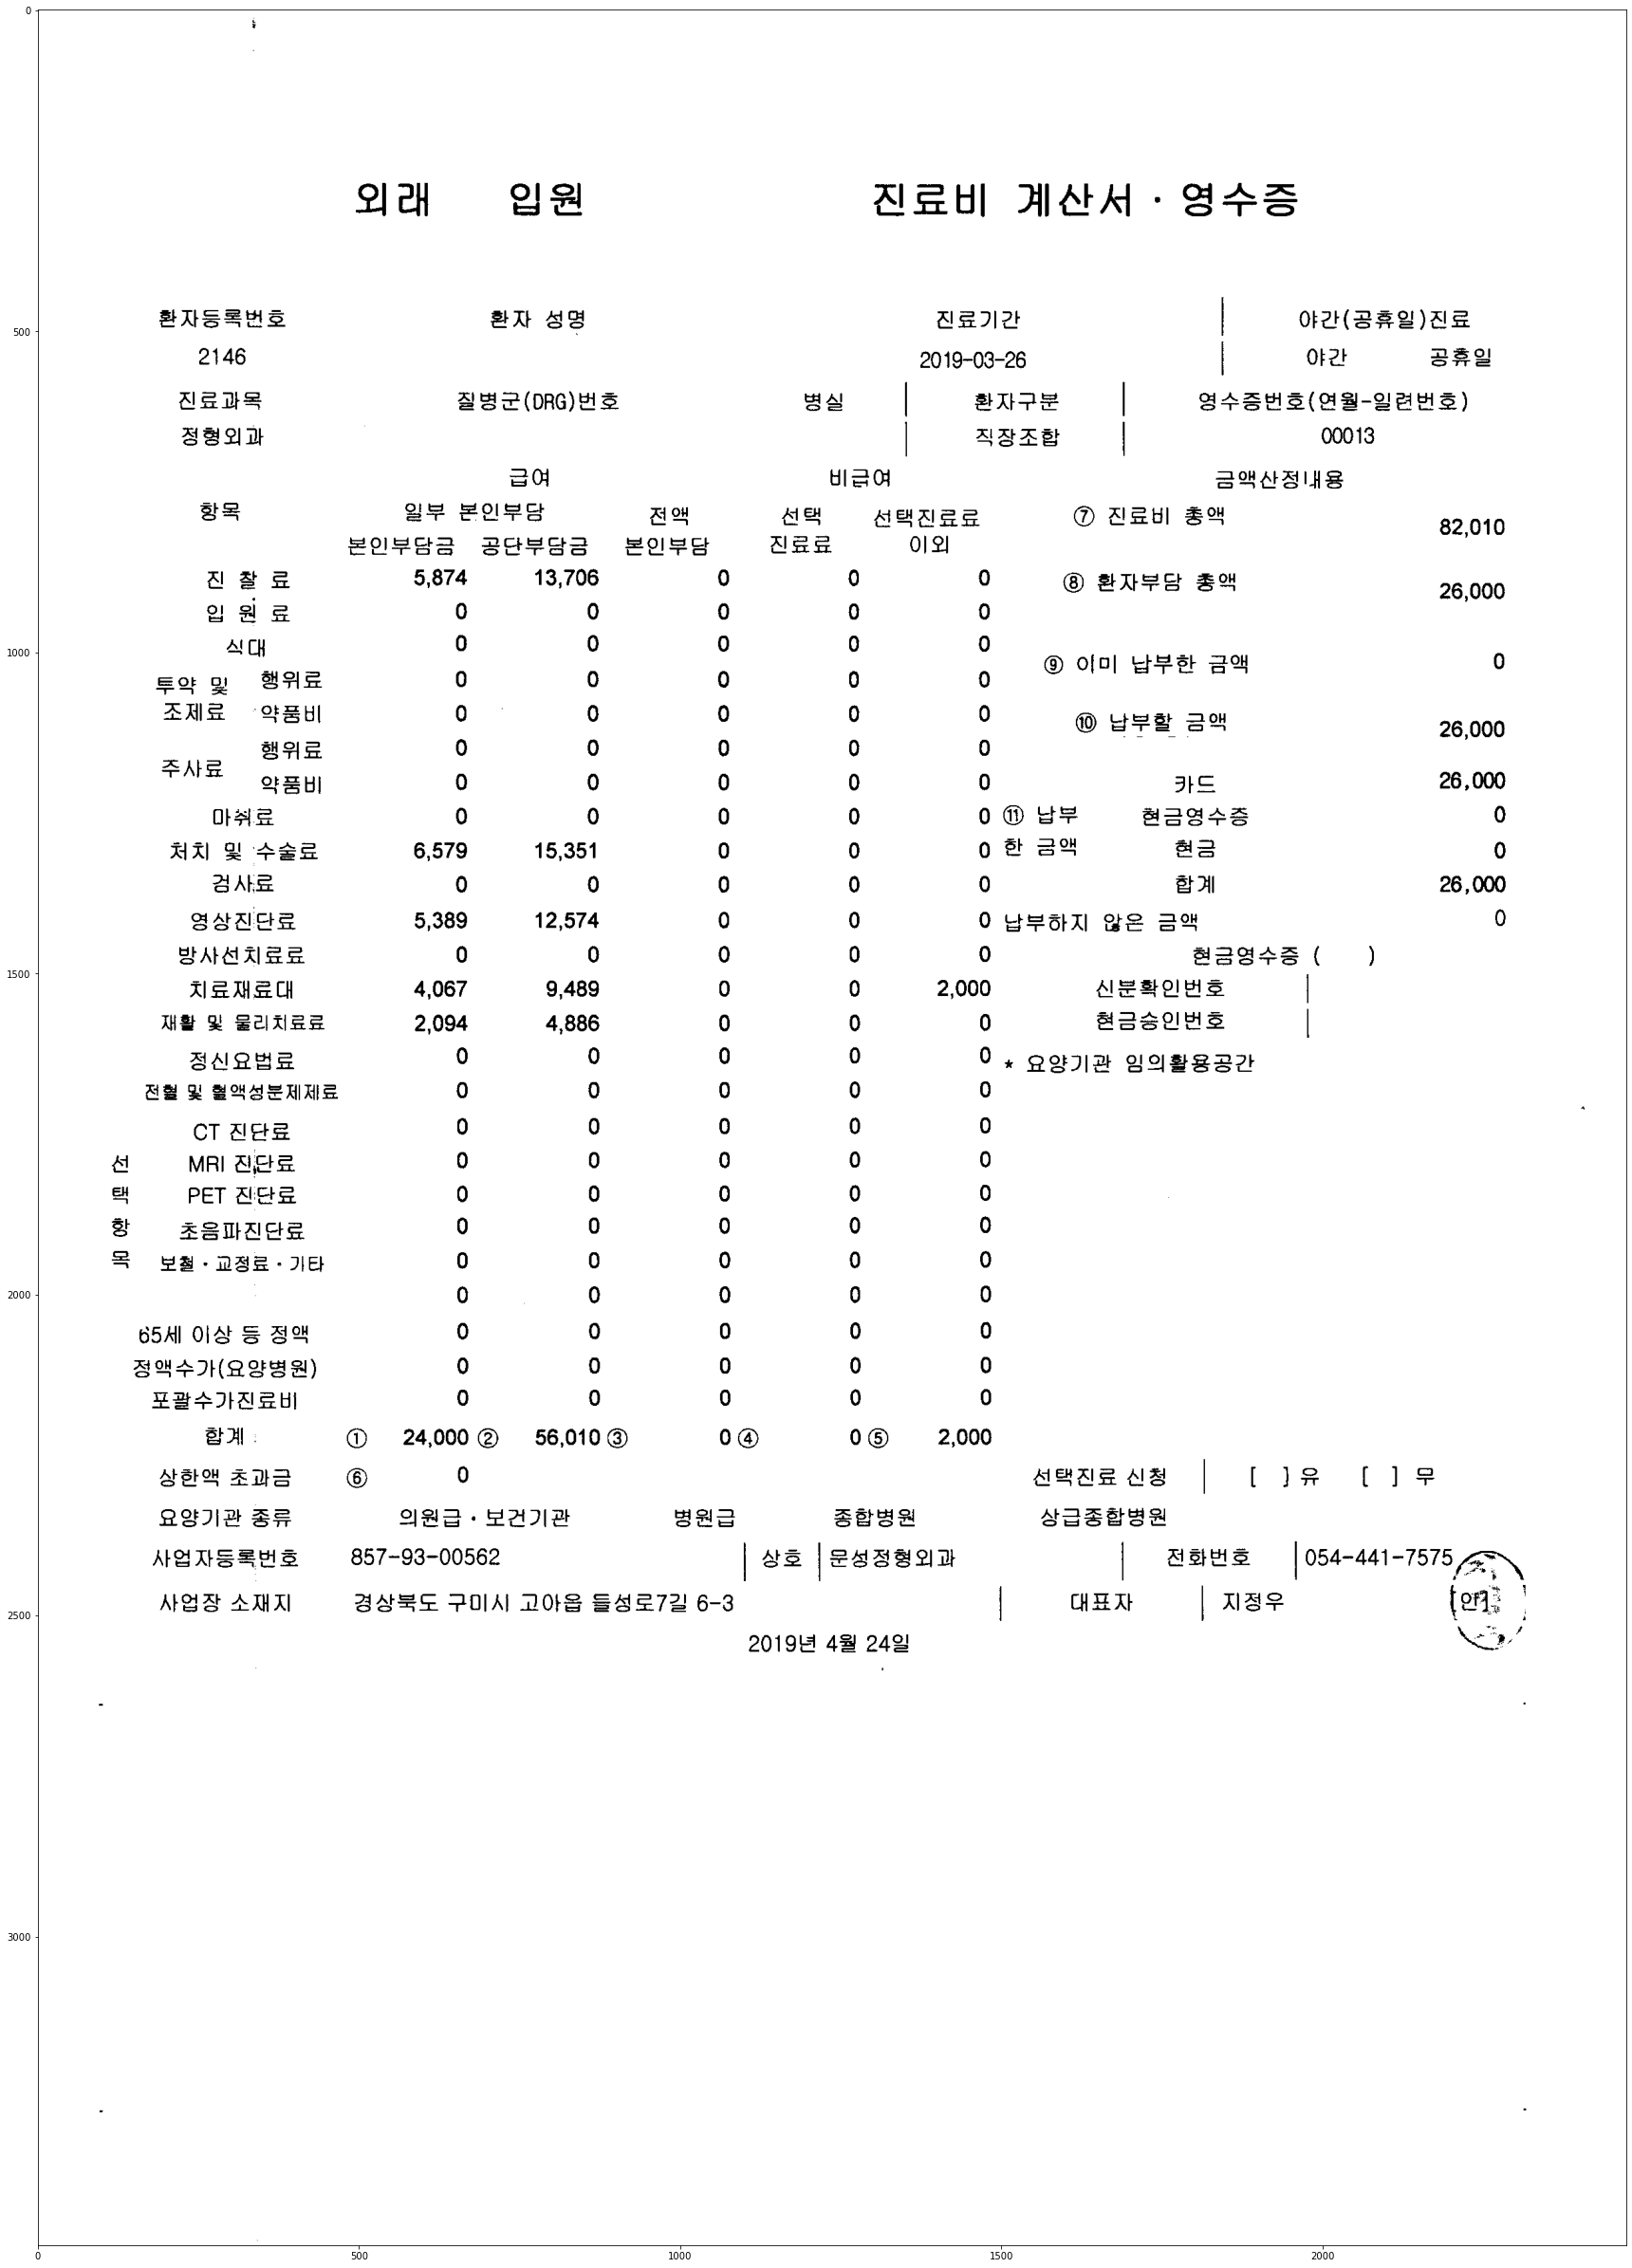

In [13]:
rm_line_img = copy.deepcopy(bi_img)
for row_id in range(dilation_row.shape[0]):
    for col_id in range(dilation_row.shape[1]):
        if dilation_row[row_id, col_id] == 0:
            rm_line_img[row_id, col_id - 100: col_id + 100] = 255
        if dilation_col[row_id, col_id] == 0:
            rm_line_img[row_id - 100: row_id + 100, col_id] = 255
imshow(rm_line_img)

* 텍스트 영역 검출

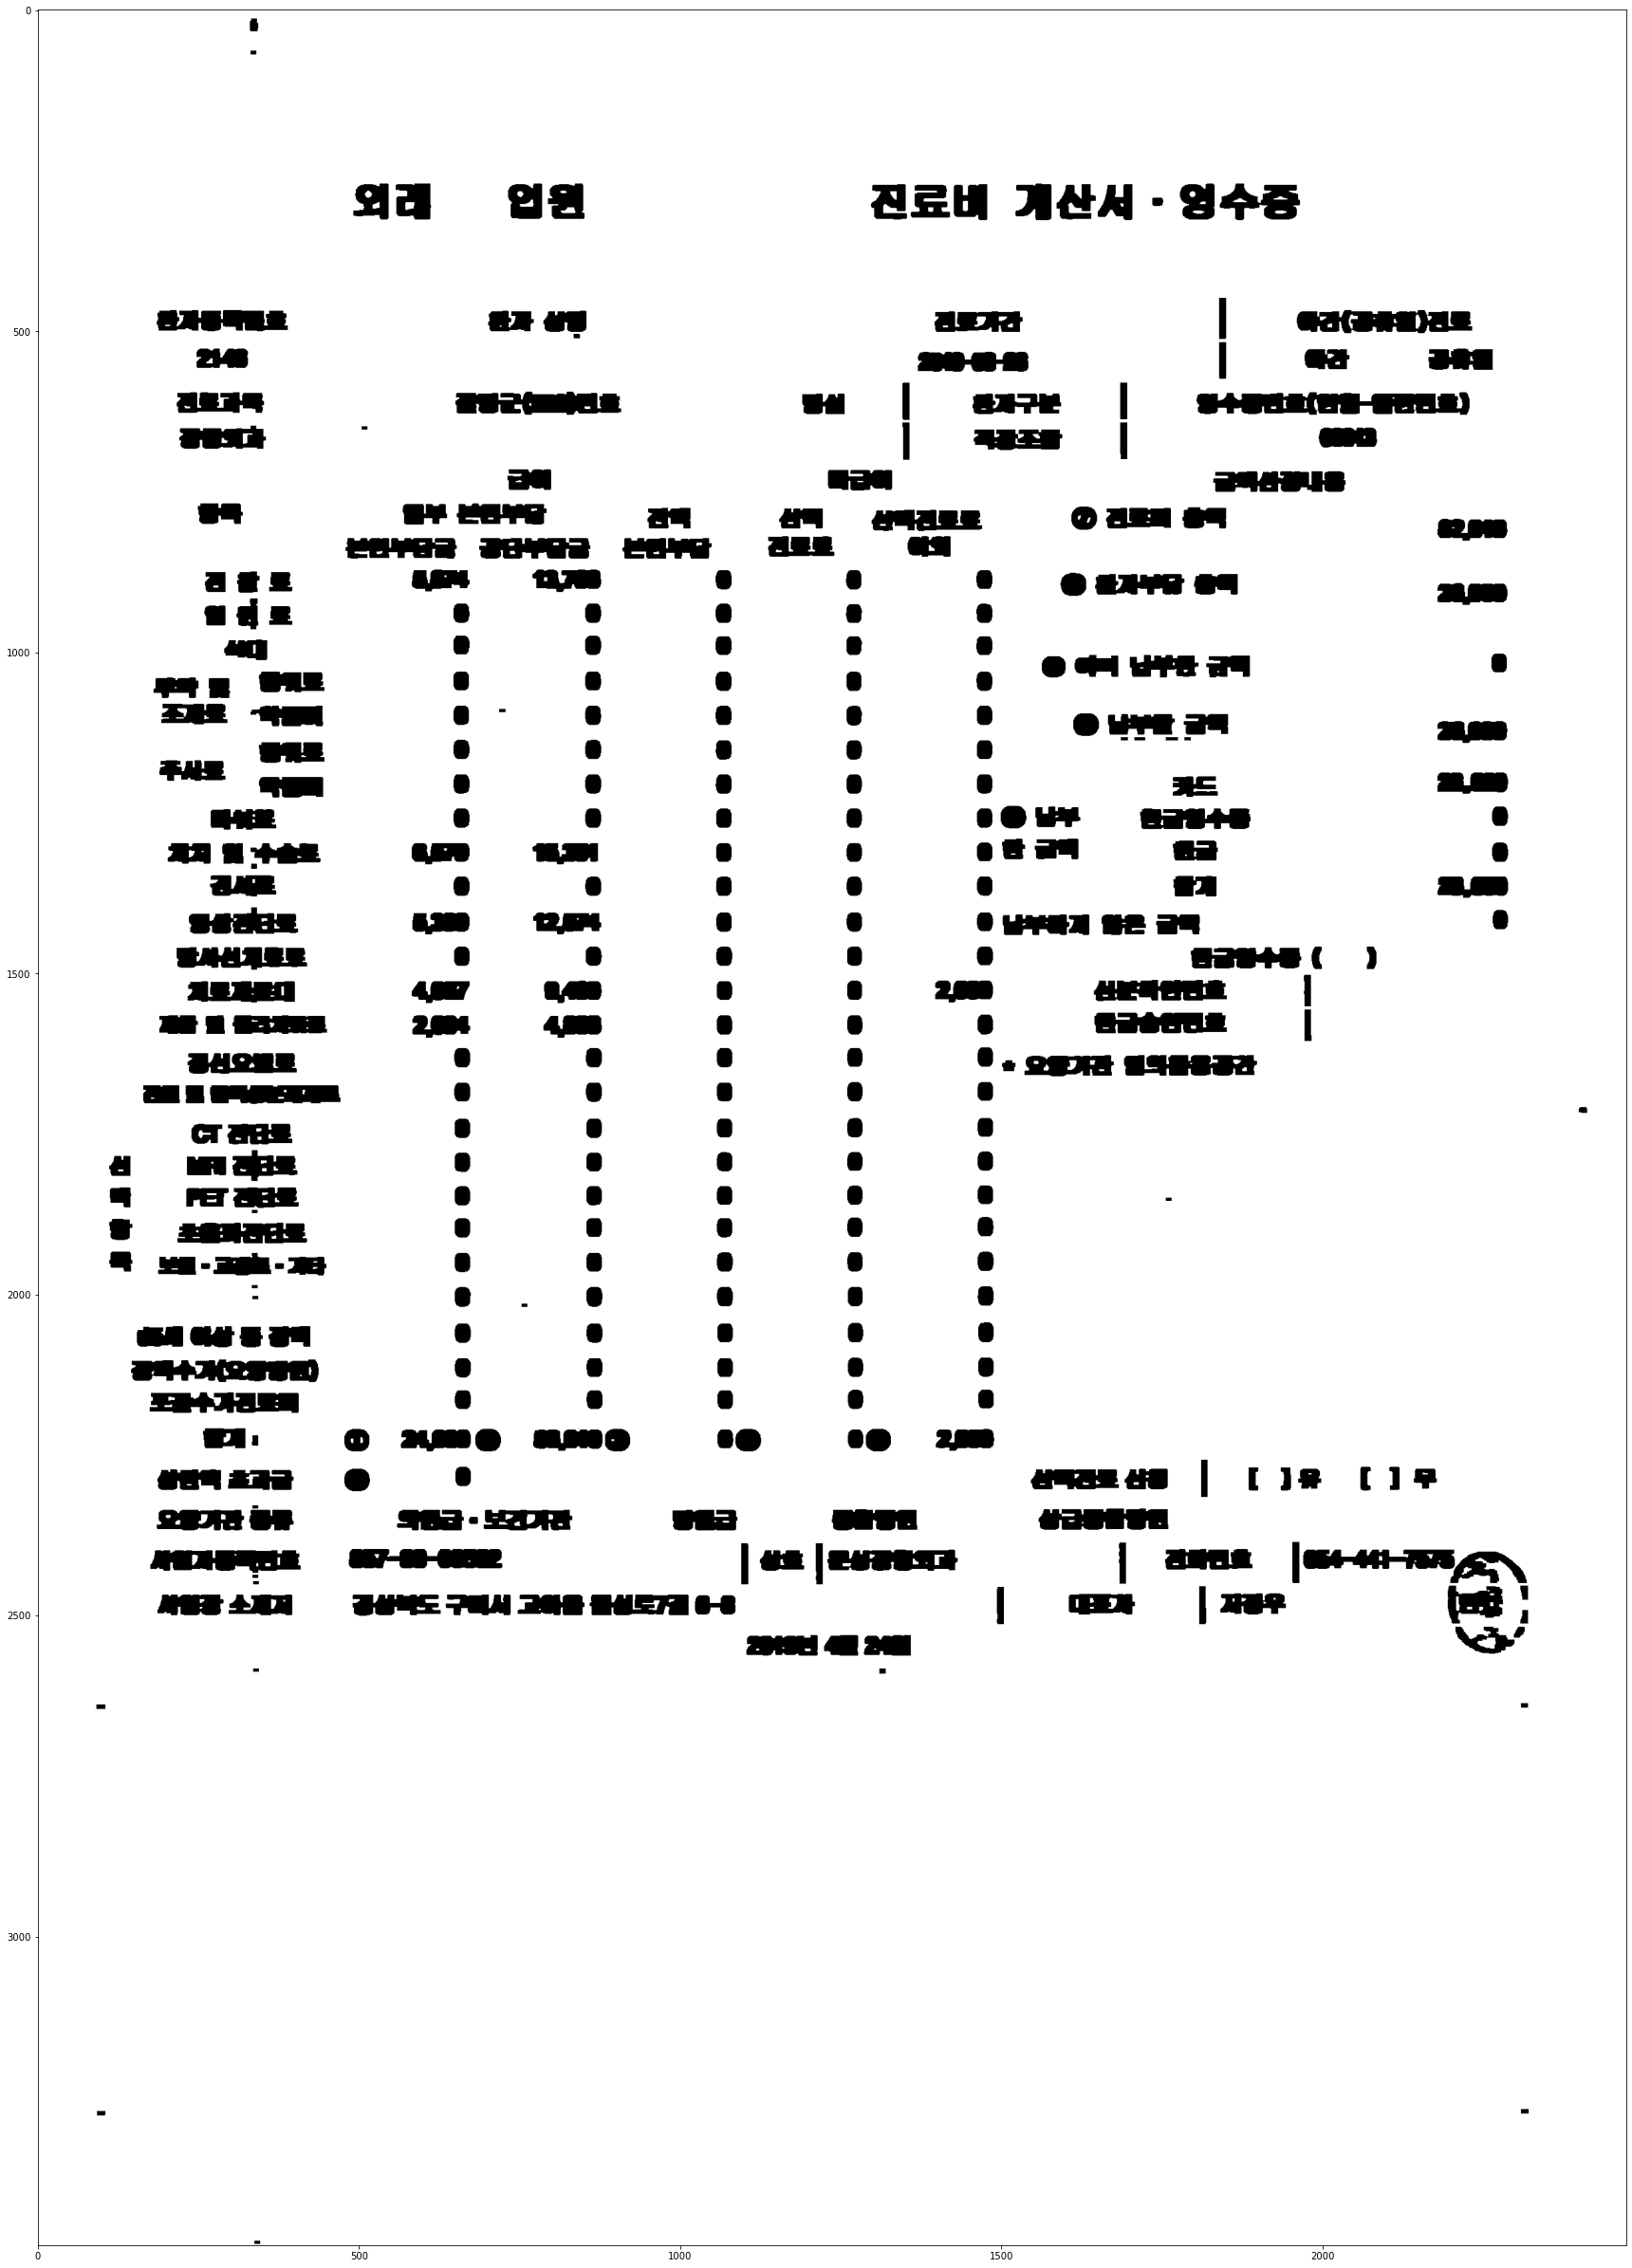

In [14]:
erod_text = np.ones((2, 3) , np.uint8)
dilate_text = np.ones((2, 3) , np.uint8)

er_text_img = cv2.erode(rm_line_img, erod_text, iterations=5)
er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=1)
# er_text_img = cv2.erode(er_text_img, erod_text, iterations=2)
# er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=2)

er_text_img = draw_edge(er_text_img, margin=1)  # 이미지 가장자리 흰색으로 칠함
imshow(er_text_img)

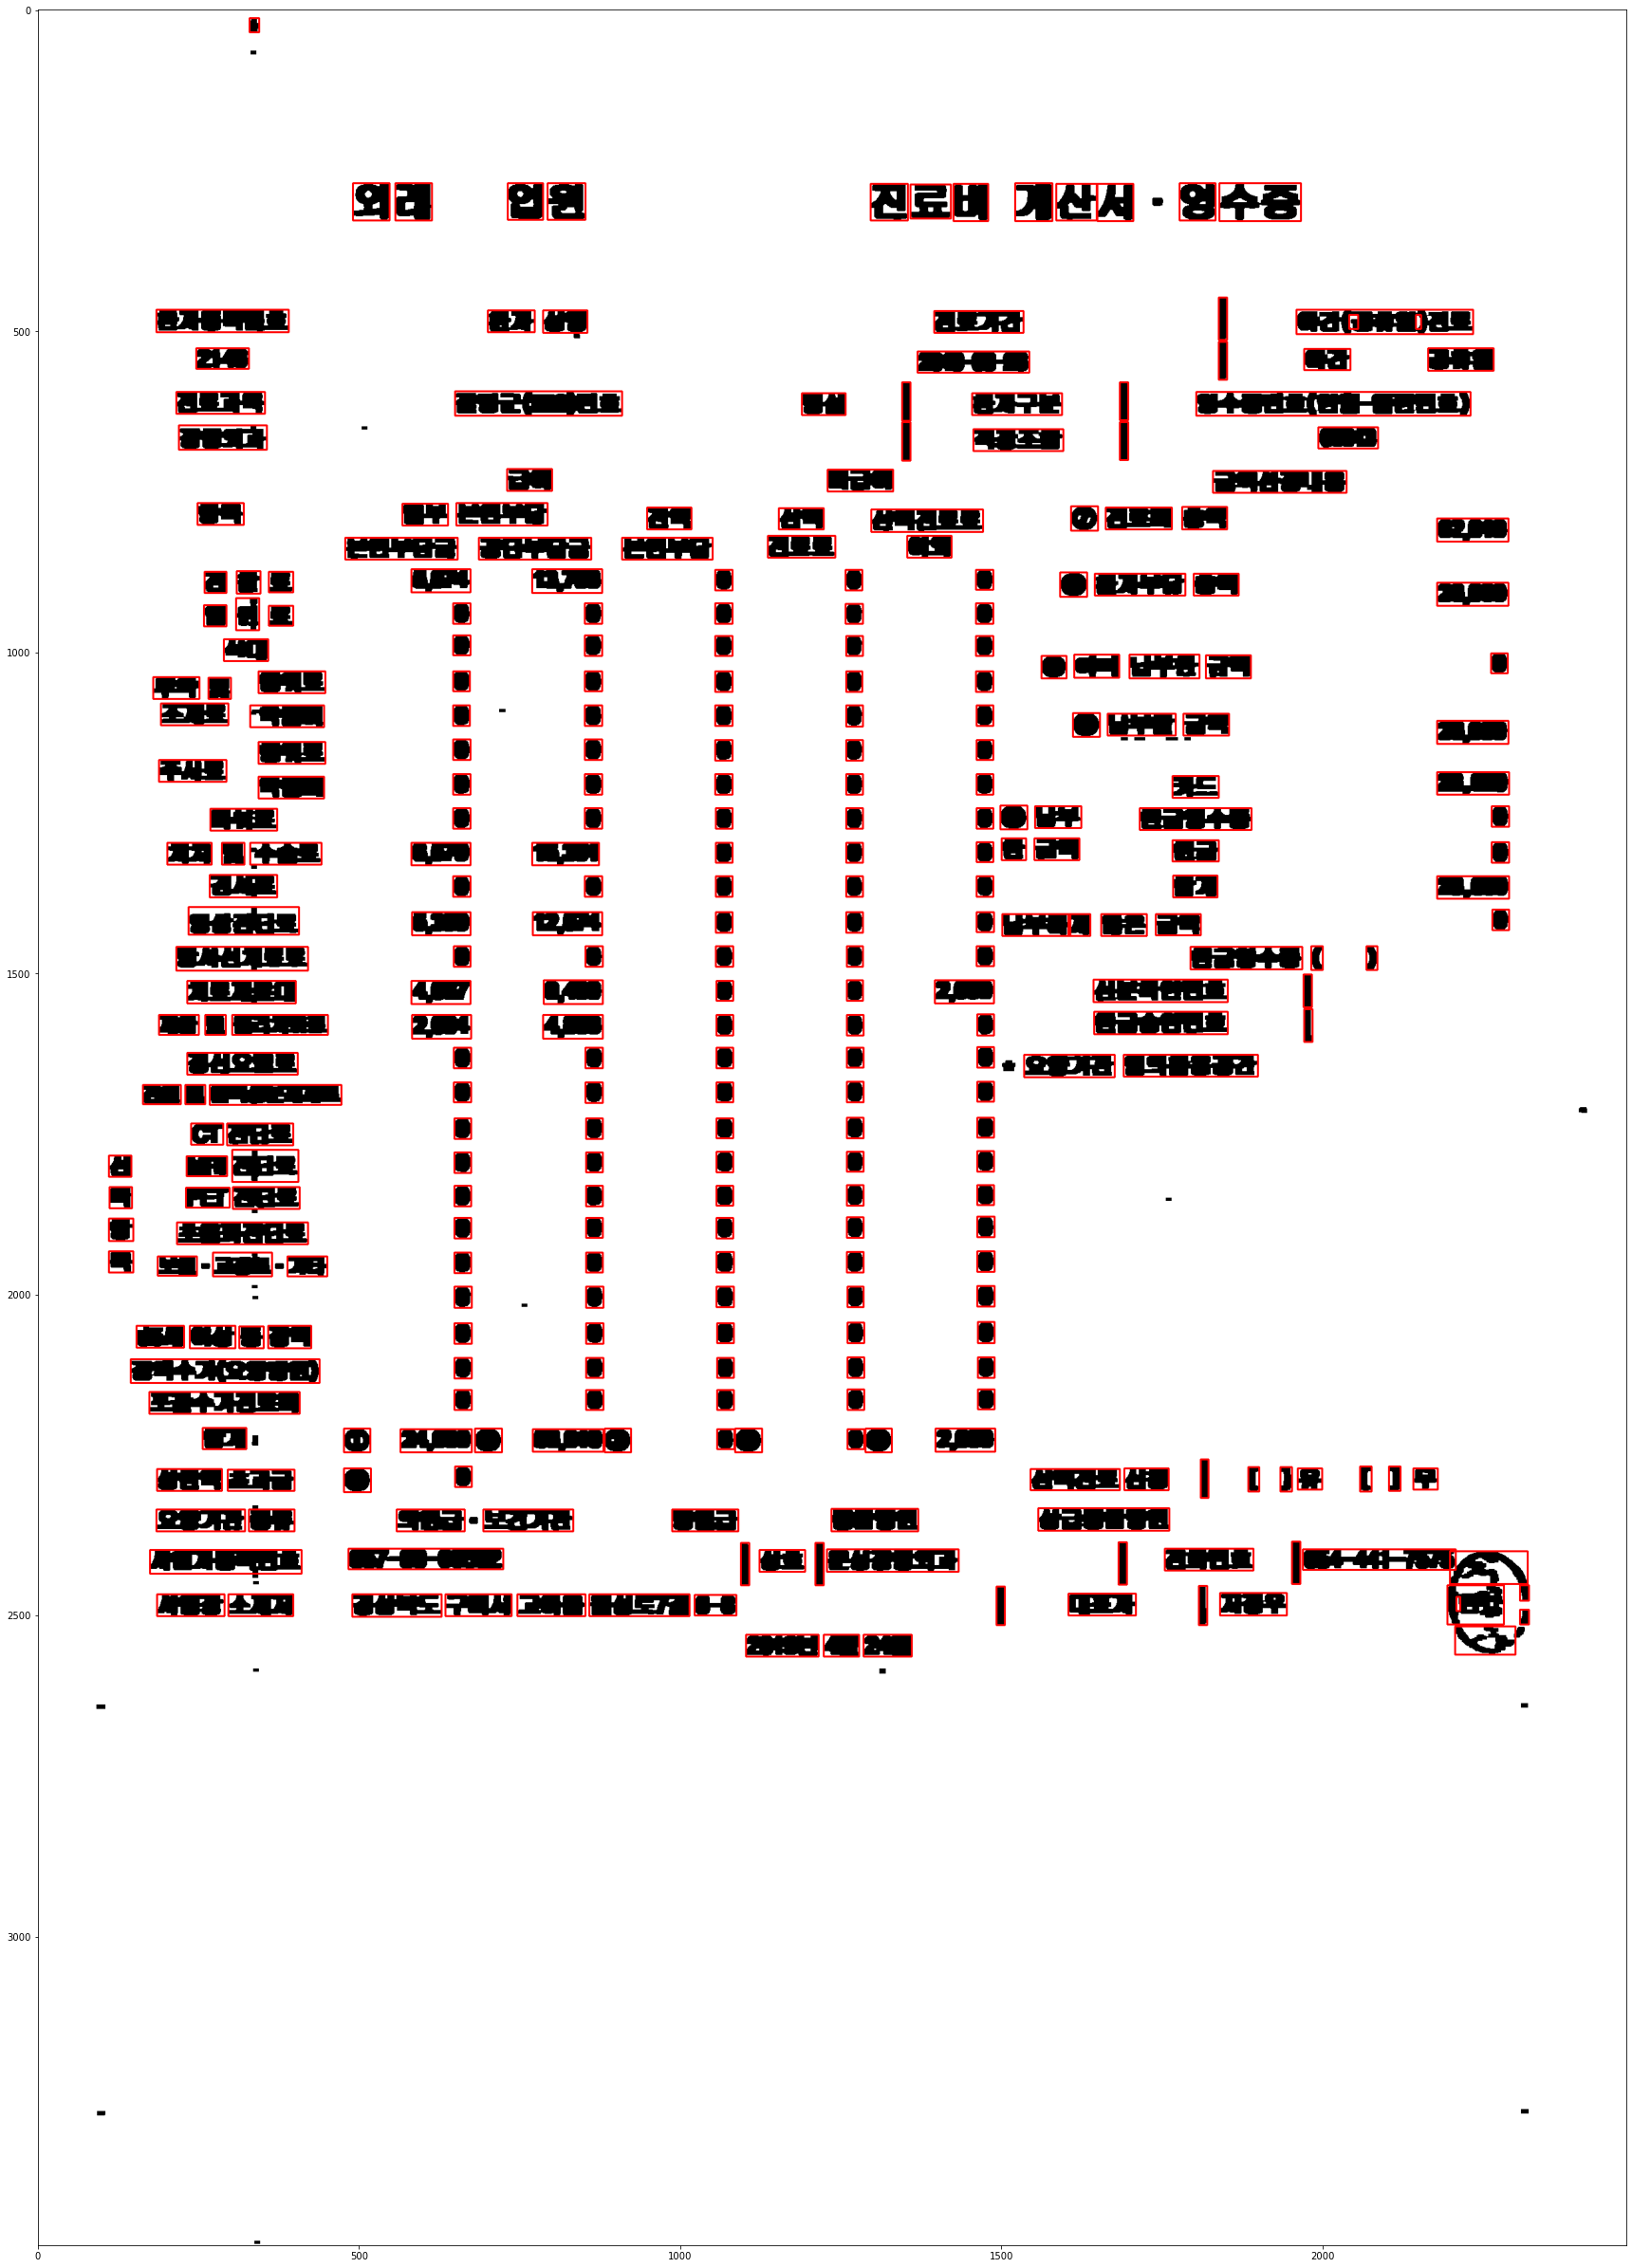

In [15]:
# get text box
back_img = cv2.cvtColor(er_text_img, cv2.COLOR_GRAY2RGB)  # 배경이미지
cnt_text, hier = cv2.findContours(er_text_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
text_area_list = list()
for cnt in cnt_text:
    x, y, w, h = cv2.boundingRect(cnt)
    # 전체 박스 제외
    if (20 < h < back_img.shape[0]-10):
        cv2.rectangle(back_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        text_area_list.append((x, y, x+w, y+h))
        
back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)
imshow(back_img)

* 라인, 셀 생성

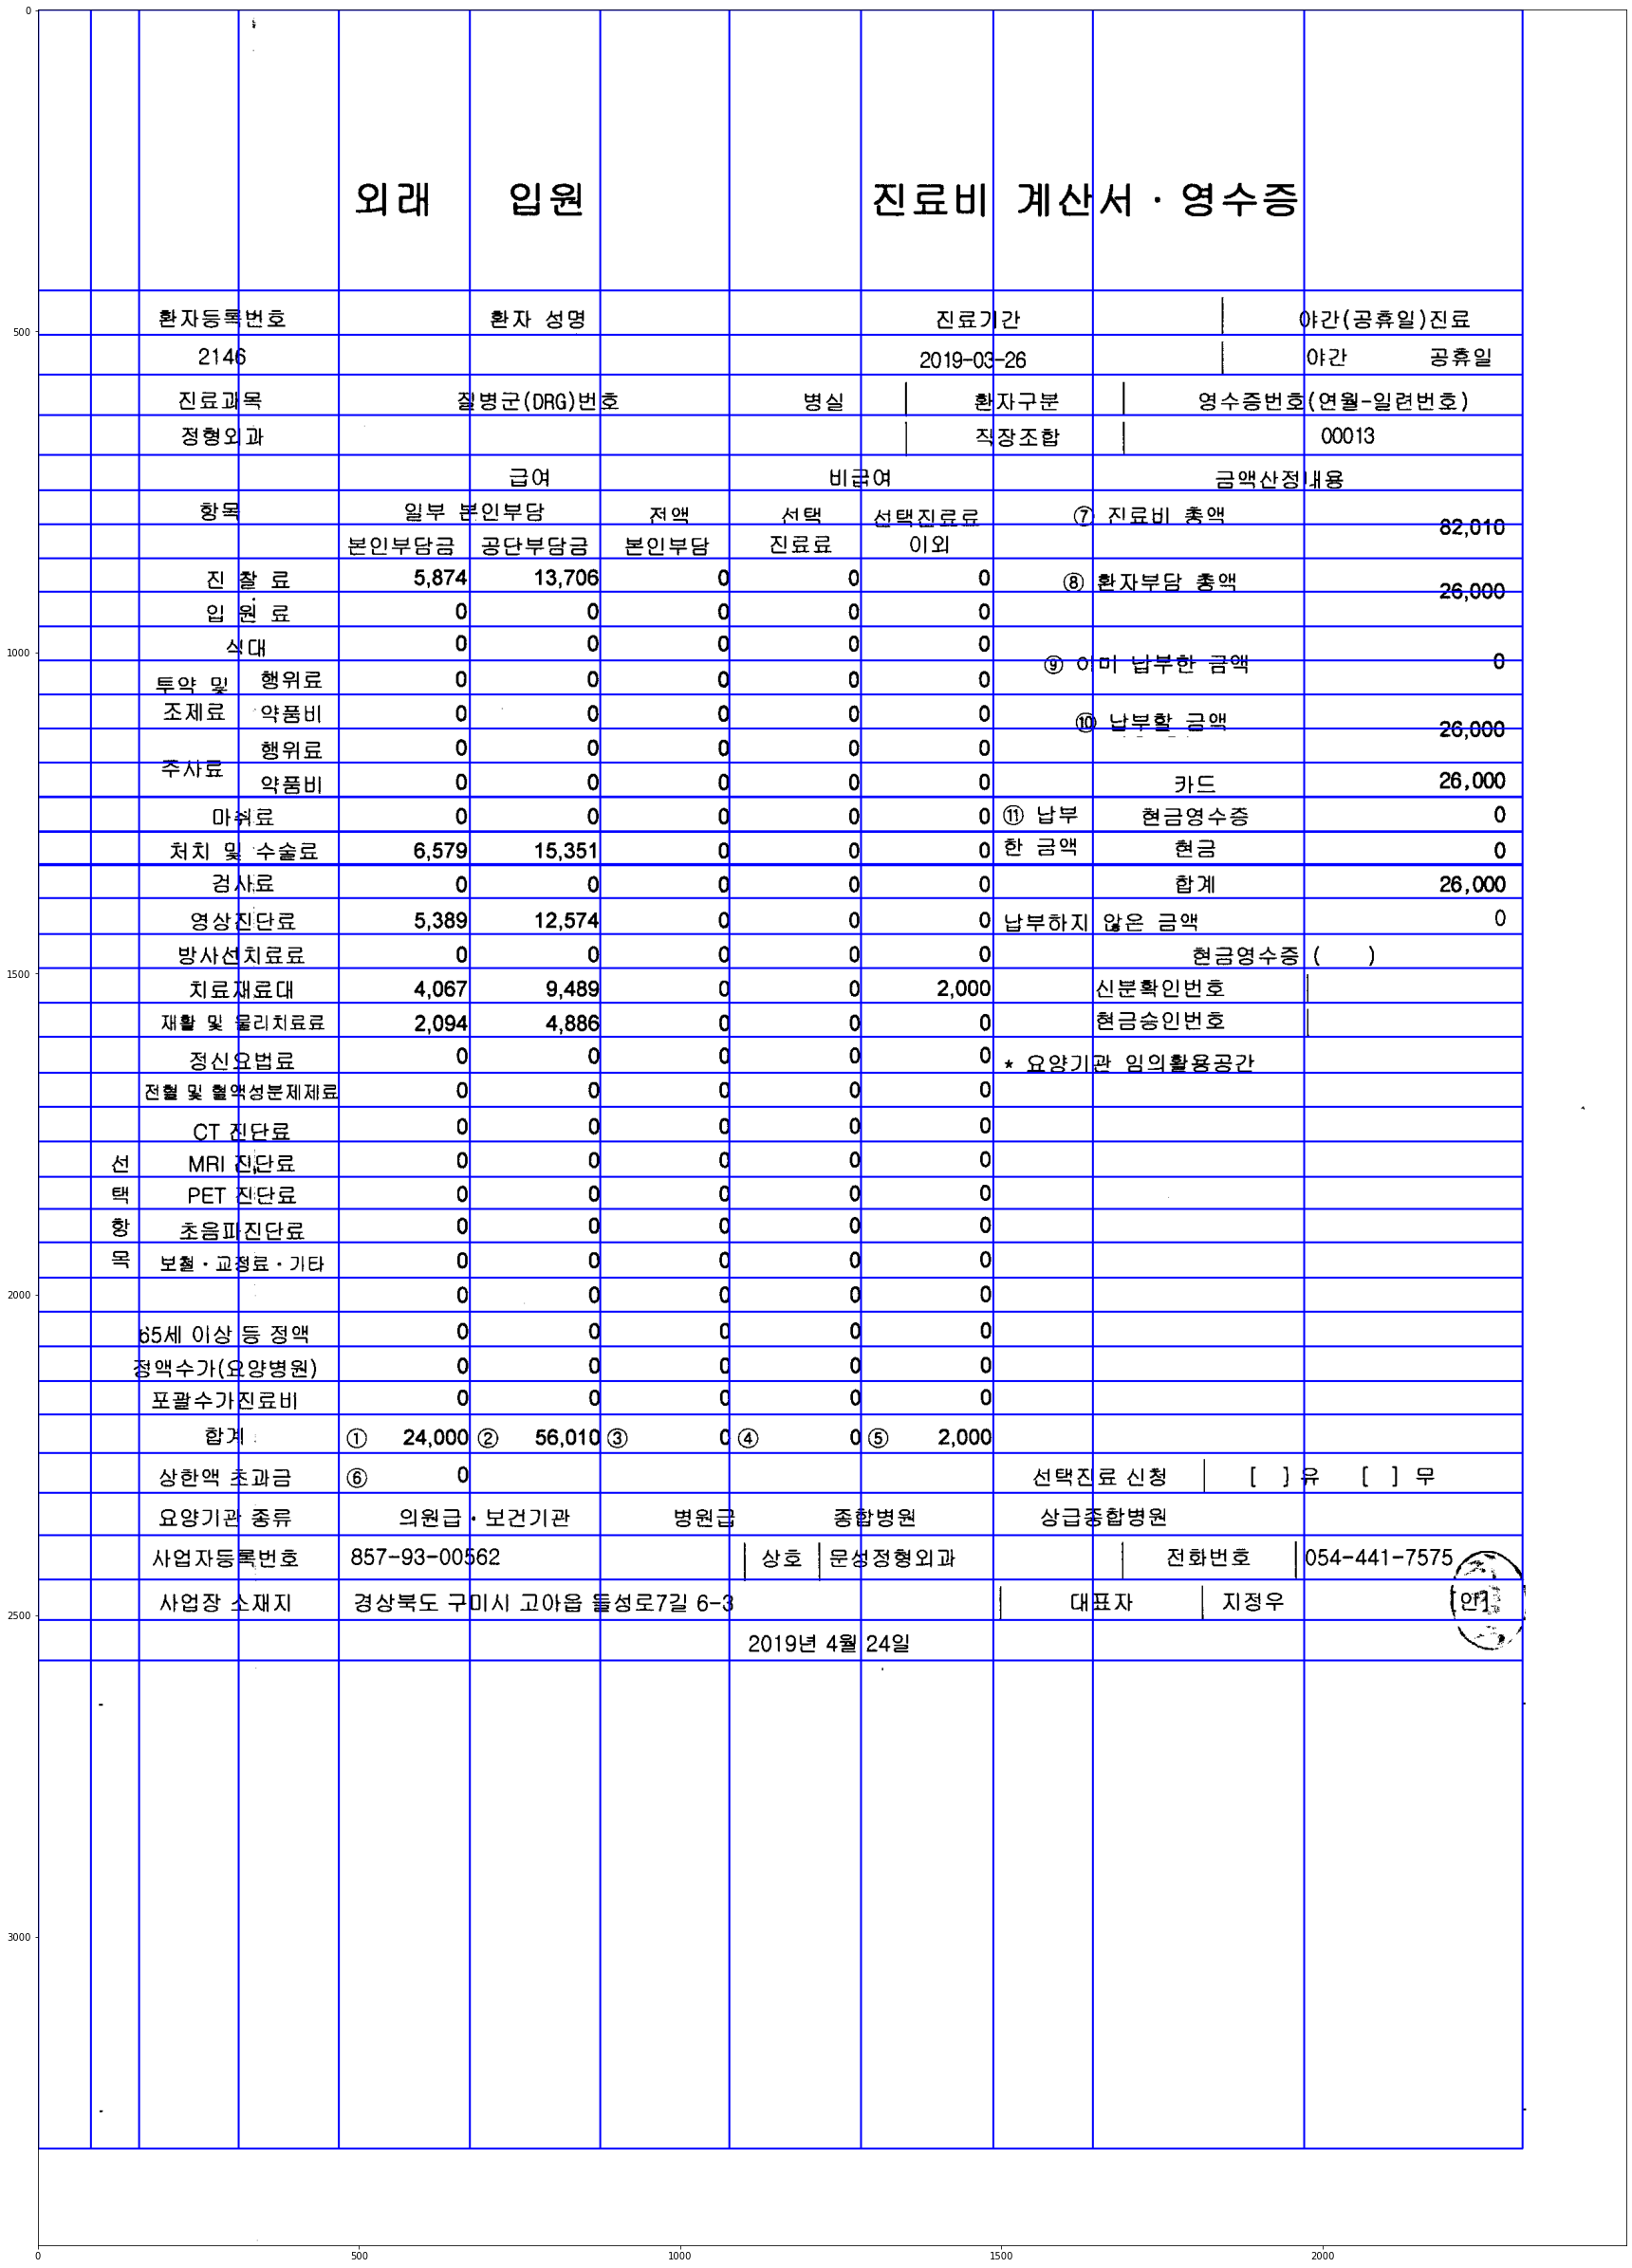

In [16]:
# 라인생성
line_x, line_y = list(), list()  # 라인 좌표
cnt_row, hierarchy = cv2.findContours(dilation_row, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt_col, hierarchy = cv2.findContours(dilation_col, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for cnt in cnt_row:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30:
        line_y.append(y)
for cnt in cnt_col:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 30:
        line_x.append(x)

line_x = sorted(line_x)
line_y = sorted(line_y)

# 셀 생성
cell_dict = dict()
cell_list = list()

for n_x, x in enumerate(line_x):
    if n_x == len(line_x) - 1:
        pass
    else:
        for n_y, y in enumerate(line_y):
            if n_y == len(line_y) - 1:
                pass
            else:
                coord = (x, y, line_x[n_x+1], line_y[n_y+1])
                cell_list.append(coord)
                cell_dict[coord] = (n_x, n_y)
# cell 확인
back_img = cv2.cvtColor(rm_line_img,cv2.COLOR_GRAY2RGB)

for cell_coord in cell_list:
    cv2.rectangle(back_img, (cell_coord[0], cell_coord[1]), (cell_coord[2], cell_coord[3]), (255, 0, 0), 2)
imshow(back_img)

* 텍스트 추출(오래걸림)

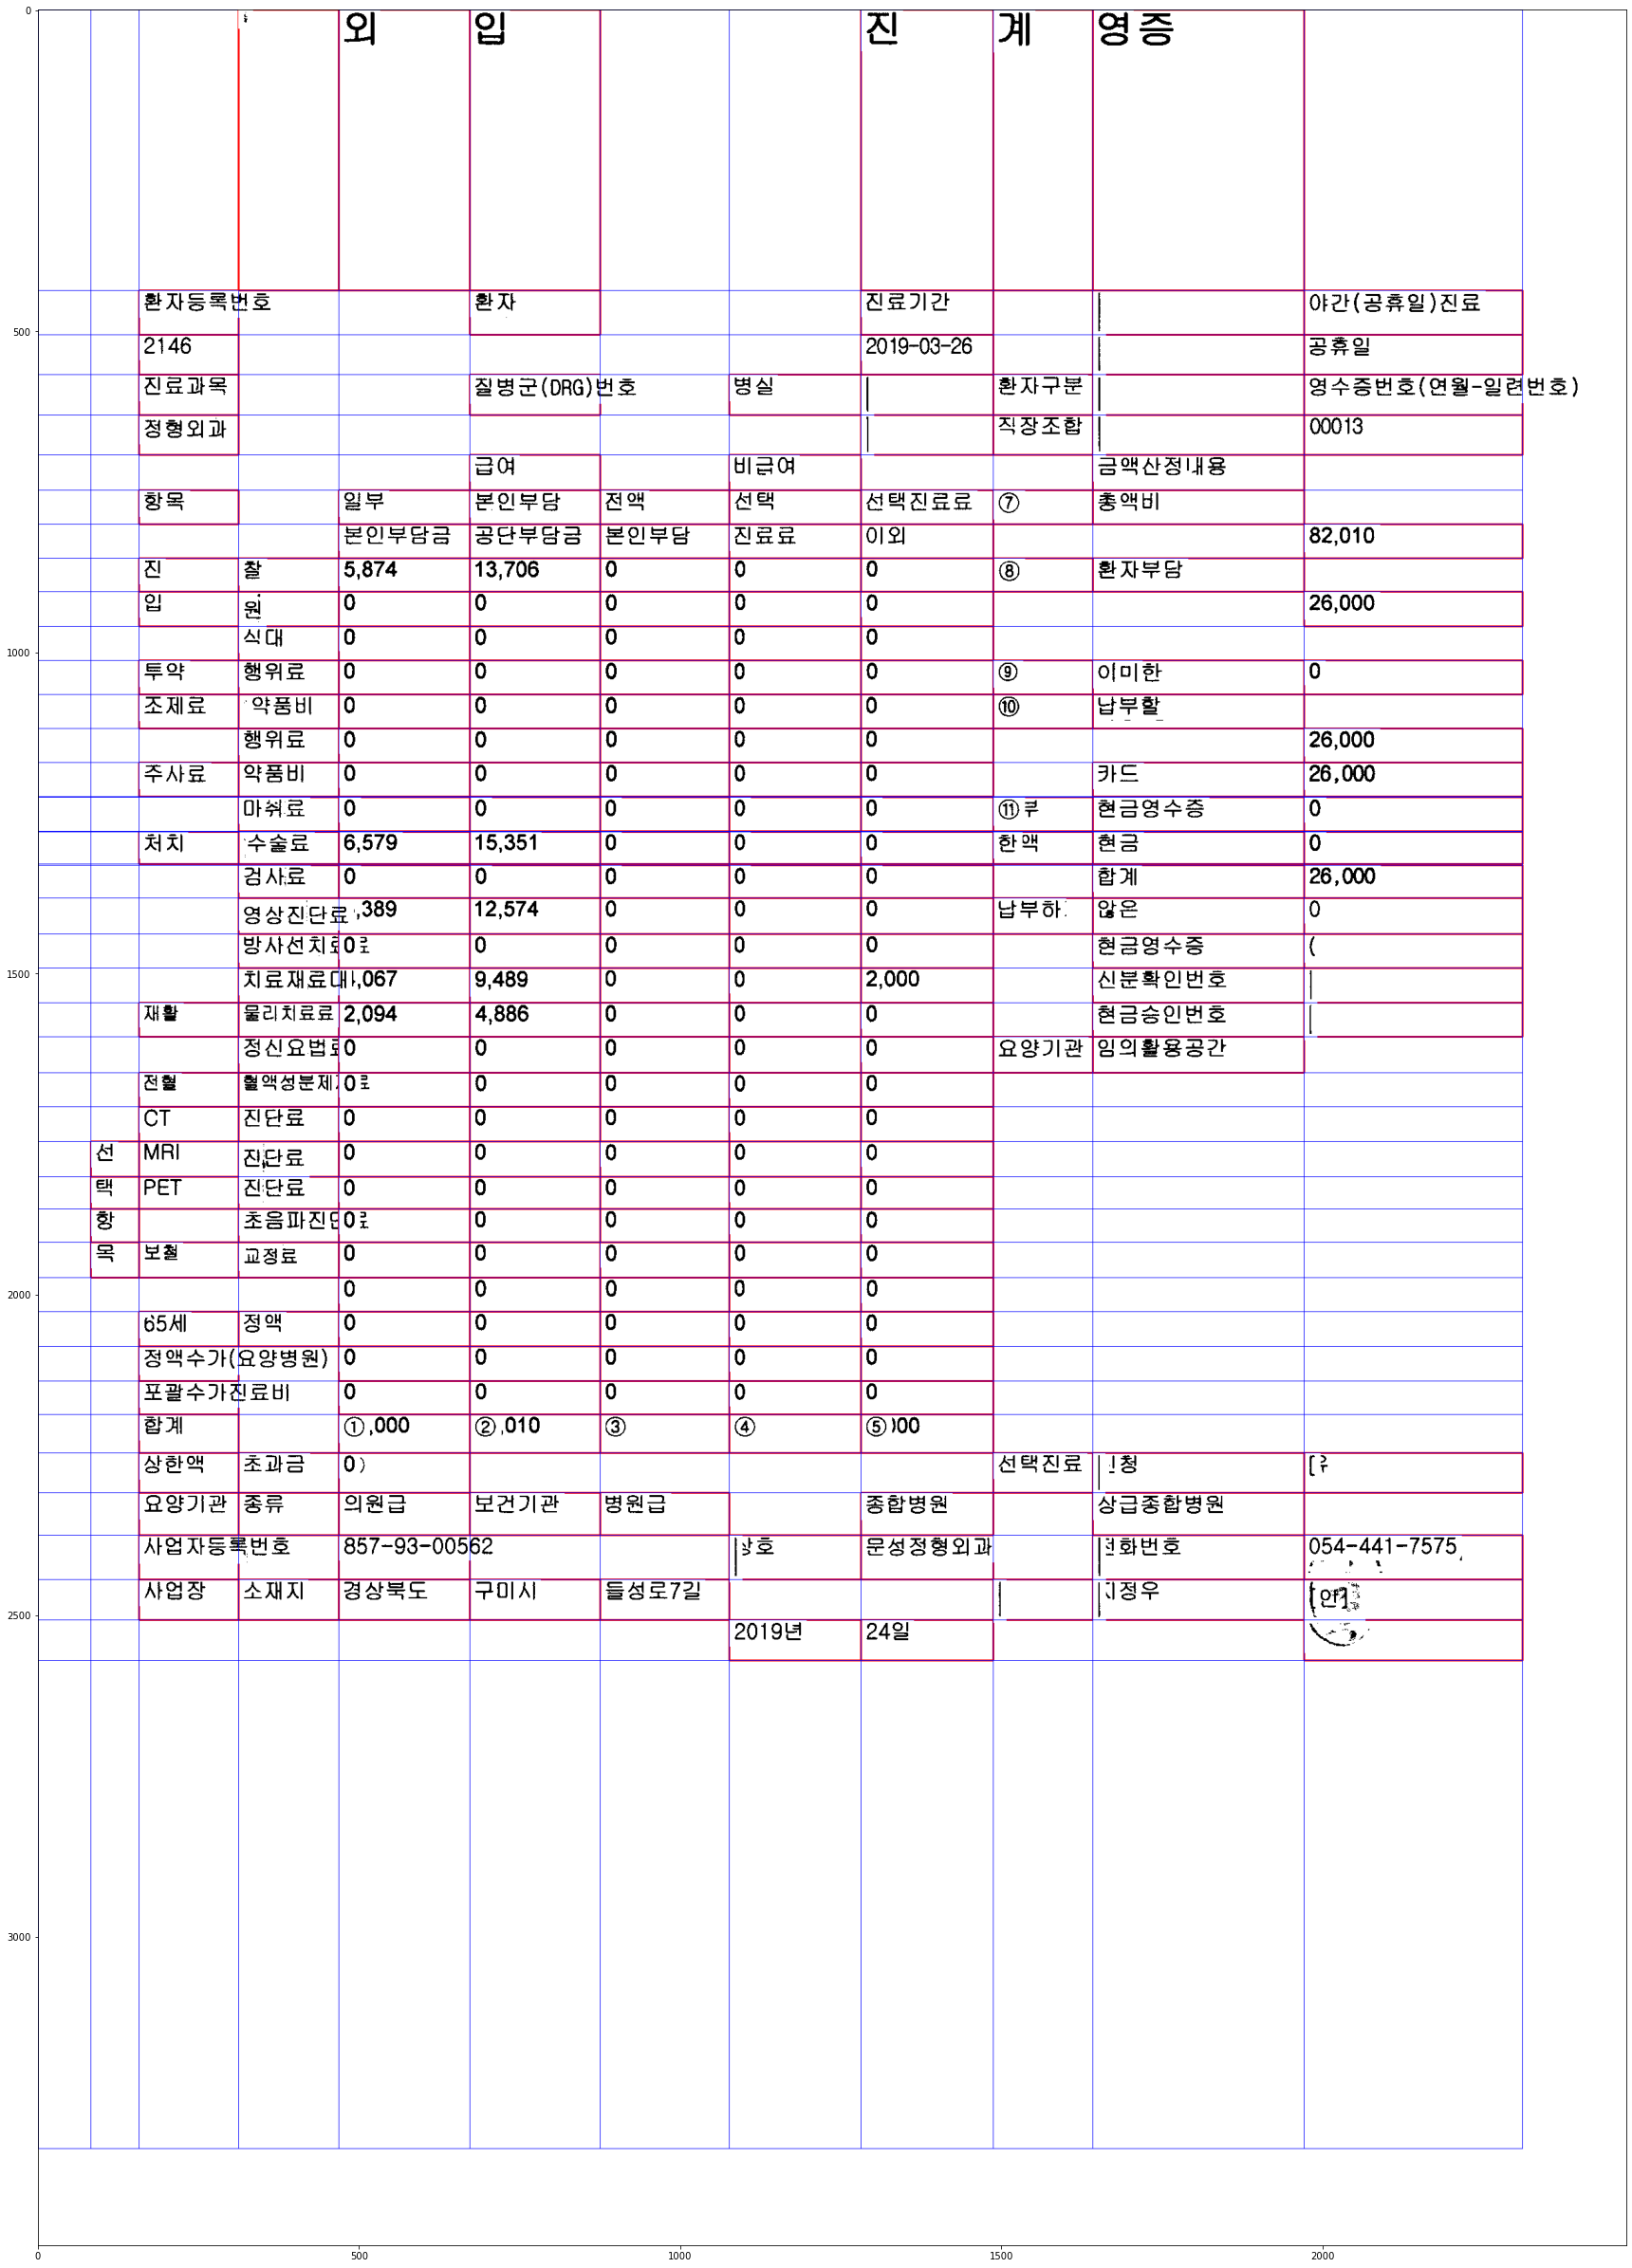

In [17]:
# 배경이미지
back_img = copy.deepcopy(rm_line_img)
back_img[:, :] = 255  # 흰색
back_img = cv2.cvtColor(back_img, cv2.COLOR_GRAY2RGB)

custom_oem_psm_config = r'--oem 1 --psm 8'
text_cell_list = list()

for text_coord in text_area_list:
    t_x1, t_y1, t_x2, t_y2 = text_coord       # 텍스트 좌표 추출
    text_mid = ((t_x1+t_x2)/2, (t_y1+t_y2)/2) # 텍스트 중간 좌표 추출
    mar = 4                                   # 텍스트 마진
    if (t_x2 + mar > rm_line_img.shape[1]) | (t_y2 + mar > rm_line_img.shape[0]):
        # 마진을 포함한 텍스트 영역이 이미지 전체 크기를 벗어날 때
        text_img = cv2.cvtColor(rm_line_img[t_y1:t_y2, t_x1:t_x2], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config)
    else:
        text_img = cv2.cvtColor(rm_line_img[t_y1 - mar :t_y2 + mar, t_x1 - mar :t_x2 + mar], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config) 
    w, h =  text_img.shape[1], text_img.shape[0]  # 텍스트 크기
    for cell_coord in cell_list:
        c_x1, c_y1, c_x2, c_y2 = cell_coord  # 셀좌표(좌상단, 우하단)
        if (c_x1 < text_mid[0] <c_x2) & (c_y1 < text_mid[1] < c_y2):
            # 텍스트 중간지점이 셀 영역 안에 있을 때
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (0, 0, 255), 2)  # 셀 영역 붉은색으로 테두리
            area = back_img[c_y1: c_y1+h, c_x1: c_x1+w]  # 텍스트 영역
            if area.shape[0] < text_img.shape[0]:
                # 셀 영역이 텍스트 영역보다 작을 때
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:-(text_img.shape[0] - area.shape[0]), :]
            elif area.shape[1] < text_img.shape[1]:
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:, :-(text_img.shape[1] - area.shape[1])]
            else:
                # 배경 이미지 내 셀 좌표를 텍스트로 표시
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img
            
            cell = cell_dict[cell_coord]  # 셀 테이블 좌표 (행, 열)
            text_cell_list.append((text, cell))  # 텍스트, 테이블 좌표 추출
            
            sp_filename = filename.split('.')[0] + '_(' + str(cell[1]) + ',' + str(cell[0]) + ')_' + str(text_coord)  + '_.' + filename.split('.')[1]
            cv2.imwrite(split_path+sp_filename, text_img)  # 파일 저장

        else:
            # 텍스트 영역이 아니면 파란색으로 테두리 칠함
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (255, 0, 0), 1)
            
cv2.imwrite('cell_img/'+filename, back_img)
imshow(back_img)

* 인식결과 표형태로 배열

In [18]:
table = np.chararray(shape=(len(line_y)-1, len(line_x)-1), itemsize=30, unicode=True)
for text_tup in text_cell_list:
    text, pos = text_tup
    table[pos[1], pos[0]] = text  +  table[pos[1], pos[0]]
table_df = pd.DataFrame(table)
table_df


,0,1,2,3,4,5,6,7,8,9,10,11
0,,,,호,외래,입원,,,진비료,계산,영수증서,
1,,,환자등록번호,,,환자성명,,,진료기간,,|,야간(공휴일)진료」
2,,,2146,,,,,,2019-038-26,,,공휴일야간
3,,,진료과목,,,질병군(매0)번호,,병실,ㅣ,환자구분,ㅣ,영수증번호(연월-일련번호)
4,,,정형외과,,,,,,ㅣ,직장조합,ㅣ,00013
5,,,,,,급여,,비급여,,,금액산정내용,
6,,,항목,,일부,본인부담,전액,선택,선택진료료,2,총액진료비,
7,,,,,본인부담금,공단부담금,본인부담,진료료,이외,,,82010
8,,,진,찰료,5874,"13,706",“。,“0,“0,(2,환자부담총액,
9,,,입,원료,“0,[9,“。ㅇ,“0,“9,,,"26,000"


In [20]:
table_df.to_csv('cell_img/' + filename + '_.csv', encoding='cp949')